In [1]:
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import pandas_datareader as pdd
from datetime import datetime
from datetime import timedelta
from meteostat import Stations, Daily
import matplotlib.collections as mcoll
import matplotlib.path as mpath
import matplotlib.cm as cm
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cpf

C:\Users\maxim\anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
plt.rcParams['font.size'] = 18
hfont = {'fontname':'DejaVu Serif'}

In [3]:
dr = pd.read_csv('results_group_h.csv', sep = ',', usecols = [0, 1, 2, 3], index_col = 'Trajectory')

9200
            Frame        x        y     Δx     Δy
Trajectory                                       
1               1  175.268   90.580  2.106  0.743
1               2  171.117   90.103 -4.151 -0.477
1               3  171.117   90.103  0.000  0.000
1               4  171.127   88.631  0.010 -1.472
1               5  172.421   90.157  1.294  1.526
...           ...      ...      ...    ...    ...
8862         1832   33.347  224.850 -0.162 -0.181
8862         1833   33.622  225.149  0.275  0.299
8862         1834   33.521  225.182 -0.101  0.033
8862         1835   33.334  225.165 -0.187 -0.017
8862         1836   33.173  225.203 -0.161  0.038

[36911 rows x 5 columns]


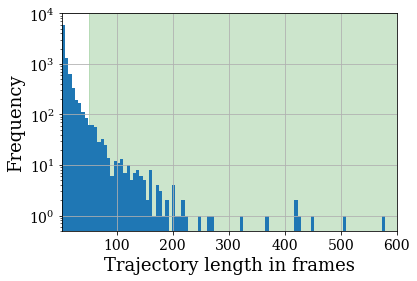

In [4]:
s = len(dr.groupby(dr.index))
print(s)
df = dr.groupby(dr.index).filter(lambda x: len(x) >= 50)
df = df.assign(Δx = df.groupby(df.index)['x'].diff().values)
df = df.assign(Δy = df.groupby(df.index)['y'].diff().values)
df = df.dropna()
print(df)
dc = pd.DataFrame()
dc['length'] = dr.groupby(dr.index).apply(lambda x: len(x))

fig = plt.figure()
ax = fig.add_subplot(111)
dc.hist(bins = 100, log = True, ax = ax)
plt.title('')
ax.set_ylim([5e-1, 1e4])
plt.fill_betweenx([0, 10000], 50, 600, alpha = 0.2, color = 'green')
plt.grid(True) ; plt.xlabel('Trajectory length in frames', **hfont) ; plt.ylabel('Frequency', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.autoscale(axis = 'x', tight = True)
plt.savefig('pics/1/histogram_trajectory_length.png', dpi = 50, bbox_inches='tight')
plt.show()

            Frame        x        y     Δx     Δy
Trajectory                                       
1               1  175.268   90.580  2.106  0.743
1               2  171.117   90.103 -4.151 -0.477
1               3  171.117   90.103  0.000  0.000
1               4  171.127   88.631  0.010 -1.472
1               5  172.421   90.157  1.294  1.526
...           ...      ...      ...    ...    ...
8858         1840  430.178  122.234  0.700  1.485
8858         1841  433.748  122.983  3.570  0.749
8858         1842  437.941  120.703  4.193 -2.280
8858         1843  435.376  117.457 -2.565 -3.246
8858         1844  435.583  114.592  0.207 -2.865

[18599 rows x 5 columns]
Number of used trajectories: 210
Difference in number of trajectories: 8990


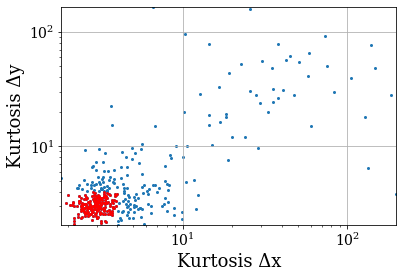

In [5]:
kc = 4 #kurtosis cutoff

dfk = df.groupby(df.index).filter(lambda x: (x['Δx'].kurtosis() + 3) <= kc and (x['Δy'].kurtosis() + 3) <= kc)
print(dfk)
e = len(dfk.groupby(dfk.index))
print('Number of used trajectories: ' + str(e))

Δs = s - e
print('Difference in number of trajectories: ' + str(Δs))

dc = pd.DataFrame()
dc['kurtx'] = df.groupby(df.index).apply(lambda x: (x['Δx'].kurtosis() + 3))
dc['kurty'] = df.groupby(df.index).apply(lambda x: (x['Δy'].kurtosis() + 3))
dc2 = pd.DataFrame()
dc2['kurtx'] = dfk.groupby(dfk.index).apply(lambda x: (x['Δx'].kurtosis() + 3))
dc2['kurty'] = dfk.groupby(dfk.index).apply(lambda x: (x['Δy'].kurtosis() + 3))

fig = plt.figure()
ax = fig.add_subplot(111)
dc.plot.scatter(x = 'kurtx', y = 'kurty', s = 4, ax = ax)
dc2.plot.scatter(x = 'kurtx', y = 'kurty', s = 3, ax = ax, color = 'red')
plt.loglog()
plt.grid(True) ; plt.xlabel('Kurtosis Δx', **hfont) ; plt.ylabel('Kurtosis Δy', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.autoscale(tight = True)
plt.savefig('pics/1/kurtosis_cutoff.png', dpi = 50, bbox_inches='tight')
plt.show()

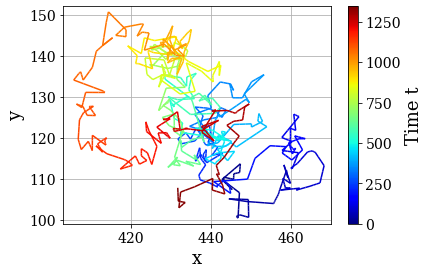

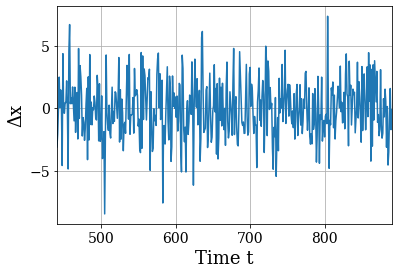

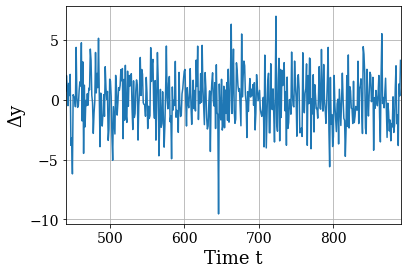

In [6]:
max_traj = dfk.groupby(dfk.index).count()['Frame'].max()
df_max = dfk.groupby(dfk.index).filter(lambda x: len(x) == max_traj)

def colorline(x, y, cmap = plt.get_cmap('jet'), linewidth = 3, alpha = 1.0):

    z = np.linspace(0.0, 1.0, len(x))
    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array = z, cmap = cmap, linewidth = linewidth, alpha = alpha)

    ax = plt.gca()
    ax.add_collection(lc)

    return lc


def make_segments(x, y):
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

x = df_max['x'].values
y = df_max['y'].values

fig, ax = plt.subplots()

path = mpath.Path(np.column_stack([x, y]))
verts = path.interpolated(steps=3).vertices
x, y = verts[:, 0], verts[:, 1]
colorline(x, y, cmap = plt.get_cmap('jet'), linewidth = 1.5)
plt.grid(True) ; plt.xlabel('x', **hfont) ; plt.ylabel('y', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
cbar = plt.colorbar(cm.ScalarMappable(norm = plt.Normalize(0.0, len(x)), cmap = plt.get_cmap('jet')))
cbar.set_label('Time t',size = 18, family = 'DejaVu Serif')
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_family('DejaVu Serif')
    l.set_size(14)
plt.axis([403, 470, 99, 152])
plt.savefig('pics/1/longest_traj.png', dpi = 50, bbox_inches='tight')
plt.show()

df_max.plot(x = 'Frame', y = 'Δx', legend = False)
plt.grid(True) ; plt.xlabel('Time t', **hfont) ; plt.ylabel('Δx', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.autoscale(axis = 'x', tight = True)
plt.savefig('pics/1/series_delta_x.png', dpi = 50, bbox_inches='tight')
plt.show()

df_max.plot(x = 'Frame', y = 'Δy', legend = False)
plt.grid(True) ; plt.xlabel('Time t', **hfont) ; plt.ylabel('Δy', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.autoscale(axis = 'x', tight = True)
plt.savefig('pics/1/series_delta_y.png', dpi = 50, bbox_inches='tight')
plt.show()

In [7]:
mean_x = dfk.groupby(dfk.index)['Δx'].mean().mean()
mean_y = dfk.groupby(dfk.index)['Δy'].mean().mean()
var_x = dfk.groupby(dfk.index)['Δx'].var().var()
var_y = dfk.groupby(dfk.index)['Δy'].var().var()
skew_x = dfk.groupby(dfk.index)['Δx'].skew().skew()
skew_y = dfk.groupby(dfk.index)['Δy'].skew().skew()
kurt_x = dfk.groupby(dfk.index)['Δx'].apply(lambda x: sps.kurtosis(x, fisher = False)).apply(lambda x: sps.kurtosis(x, fisher = False))
kurt_y = dfk.groupby(dfk.index)['Δy'].apply(lambda x: sps.kurtosis(x, fisher = False)).apply(lambda x: sps.kurtosis(x, fisher = False))

In [8]:
dfk = dfk.assign(Δx_n = dfk.groupby(dfk.index)['Δx'].apply(lambda x: (x - np.mean(x)) / np.std(x)))
dfk = dfk.assign(Δy_n = dfk.groupby(dfk.index)['Δy'].apply(lambda x: (x - np.mean(x)) / np.std(x)))
dfk

,Frame,x,y,Δx,Δy,Δx_n,Δy_n
Trajectory,,,,,,,
1,1,175.268,90.580,2.106,0.743,0.879191,0.382696
1,2,171.117,90.103,-4.151,-0.477,-1.306811,-0.200088
1,3,171.117,90.103,0.000,0.000,0.143420,0.027771
1,4,171.127,88.631,0.010,-1.472,0.146914,-0.675391
1,5,172.421,90.157,1.294,1.526,0.595503,0.756728
...,...,...,...,...,...,...,...
8858,1840,430.178,122.234,0.700,1.485,0.335296,0.493484
8858,1841,433.748,122.983,3.570,0.749,1.535379,0.212854
8858,1842,437.941,120.703,4.193,-2.280,1.795885,-0.942076


In [9]:
cmean_x = dfk['Δx_n'].mean()
cmean_y = dfk['Δy_n'].mean()
cvar_x = dfk['Δx_n'].var()
cvar_y = dfk['Δy_n'].var()
cskew_x = dfk['Δx_n'].skew()
cskew_y = dfk['Δy_n'].skew()
ckurt_x = dfk['Δx_n'].kurtosis() + 3
ckurt_y = dfk['Δy_n'].kurtosis() + 3
                          
print(cmean_x, cmean_y, cvar_x, cvar_y, cskew_x, cskew_y, ckurt_x, ckurt_y)

1.3475608785909408e-18 8.356966688936067e-19 1.000053769222502 1.0000537692225007 0.013393456218578277 -0.030451237451740897 2.93997829346952 3.0095933204921286


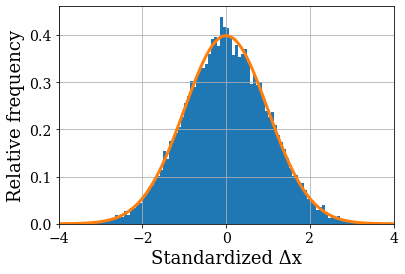

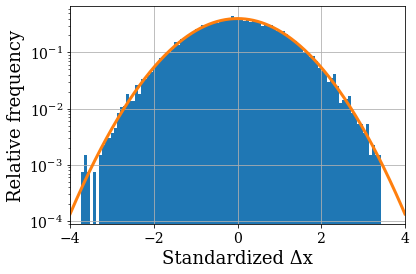

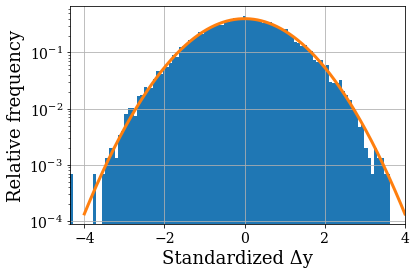

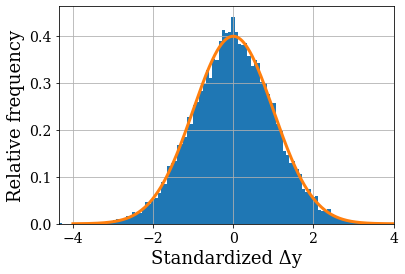

In [10]:
dfk.hist(column = 'Δx_n', density = True, bins = 100)
plt.plot(np.linspace(-4, 4, 1000), sps.norm.pdf(np.linspace(-4, 4, 1000)), linewidth = 3)
plt.xlabel('Standardized Δx', **hfont) ; plt.ylabel('Relative frequency', **hfont)
plt.title('')
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.autoscale(axis = 'x', tight = True)
plt.savefig('pics/1/stand_delta_x.png', dpi = 50, bbox_inches='tight')
plt.show()

dfk.hist(column = 'Δx_n', density = True, log = True, bins = 100)
plt.plot(np.linspace(-4, 4, 1000), sps.norm.pdf(np.linspace(-4, 4, 1000)), linewidth = 3)
plt.xlabel('Standardized Δx', **hfont) ; plt.ylabel('Relative frequency', **hfont)
plt.semilogy()
plt.title('')
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.autoscale(axis = 'x', tight = True)
plt.savefig('pics/1/stand_delta_x_log.png', dpi = 50, bbox_inches='tight')
plt.show()

dfk.hist(column = 'Δy_n', density = True, log = True, bins = 100)
plt.plot(np.linspace(-4, 4, 1000), sps.norm.pdf(np.linspace(-4, 4, 1000)), linewidth = 3)
plt.xlabel('Standardized Δy', **hfont) ; plt.ylabel('Relative frequency', **hfont)
plt.semilogy()
plt.title('')
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.autoscale(axis = 'x', tight = True)
plt.savefig('pics/1/stand_delta_y.png', dpi = 50, bbox_inches='tight')
plt.show()

dfk.hist(column = 'Δy_n', density = True, bins = 100)
plt.plot(np.linspace(-4, 4, 1000), sps.norm.pdf(np.linspace(-4, 4, 1000)), linewidth = 3)
plt.xlabel('Standardized Δy', **hfont) ; plt.ylabel('Relative frequency', **hfont)
plt.title('')
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.autoscale(axis = 'x', tight = True)
plt.savefig('pics/1/stand_delta_y_log.png', dpi = 50, bbox_inches='tight')
plt.show()

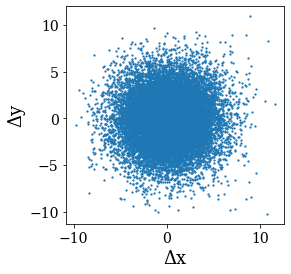

In [11]:
ax = dfk.plot(kind = 'scatter', x = 'Δx', y = 'Δy', s = 1.5)
plt.xlabel('Δx', **hfont) ; plt.ylabel('Δy', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
ax.set_aspect('equal')
plt.savefig('pics/1/scatter_xy.png', dpi = 50, bbox_inches='tight')

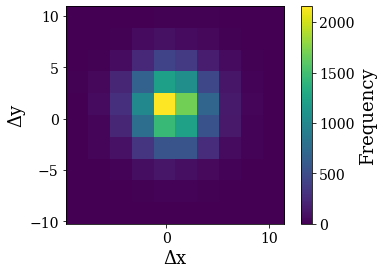

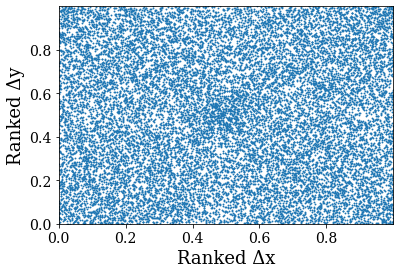

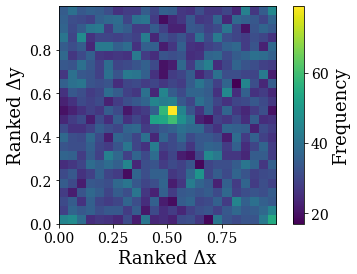

In [12]:
def qrank(series):
    return (series.argsort().argsort() - 0.5) / len(series)

heatmap, xedges, yedges = np.histogram2d(dfk['Δx'], dfk['Δy'], bins=(10, 10))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.ylabel('Δy', **hfont)
plt.xlabel('Δx', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.imshow(heatmap, extent = extent)
cbar = plt.colorbar()
cbar.set_label('Frequency',size = 18, family = 'DejaVu Serif')
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_family('DejaVu Serif')
    l.set_size(14)
plt.savefig('pics/1/heatmap_xy.png', dpi = 50, bbox_inches='tight')
plt.show()

x_r = qrank(dfk['Δx'])
y_r = qrank(dfk['Δy'])

plt.scatter(x_r, y_r, s = 0.75)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xlabel('Ranked Δx', **hfont) ; plt.ylabel('Ranked Δy', **hfont)
plt.autoscale(tight = True)
plt.savefig('pics/1/scatter_ranked_xy.png', dpi = 50, bbox_inches='tight')
plt.show()

heatmap, xedges, yedges = np.histogram2d(x_r, y_r, bins=(24, 24))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.ylabel('Ranked Δy', **hfont)
plt.xlabel('Ranked Δx', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.imshow(heatmap, extent = extent)
cbar = plt.colorbar()
cbar.set_label('Frequency', size = 18, family = 'DejaVu Serif')
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_family('DejaVu Serif')
    l.set_size(14)
plt.savefig('pics/1/heatmap_ranked_xy.png', dpi = 50, bbox_inches='tight')
plt.show()

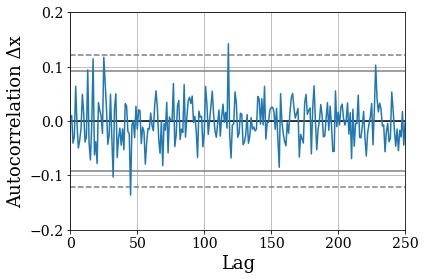

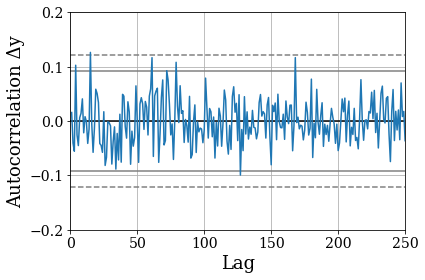

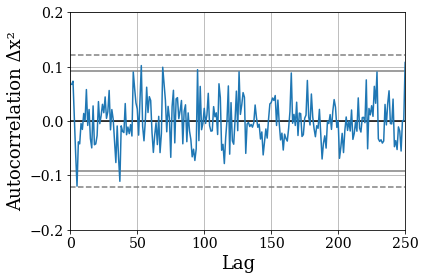

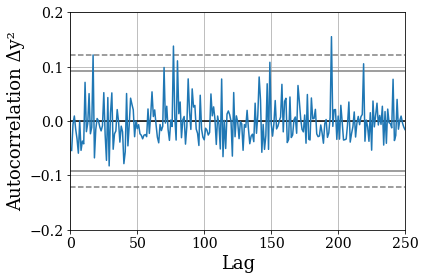

In [13]:
x = pd.plotting.autocorrelation_plot(df_max['Δx']) 
x.plot
plt.axis([0, 250, -0.2, 0.2])
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xlabel('Lag', **hfont) ; plt.ylabel('Autocorrelation Δx', **hfont)
plt.savefig('pics/1/autcorr_x.png', dpi = 50, bbox_inches='tight')
plt.show()

y = pd.plotting.autocorrelation_plot(df_max['Δy']) 
plt.axis([0, 250, -0.2, 0.2])
y.plot
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xlabel('Lag', **hfont) ; plt.ylabel('Autocorrelation Δy', **hfont)
plt.savefig('pics/1/autcorr_y.png', dpi = 50, bbox_inches='tight')
plt.show()

x2 = pd.plotting.autocorrelation_plot(df_max['Δx'].apply(lambda x: x ** 2)) 
x2.plot
plt.axis([0, 250, -0.2, 0.2])
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xlabel('Lag', **hfont) ; plt.ylabel('Autocorrelation Δx²', **hfont)
plt.savefig('pics/1/autcorr_x_sq.png', dpi = 50, bbox_inches='tight')
plt.show()

y2 = pd.plotting.autocorrelation_plot(df_max['Δy'].apply(lambda x: x ** 2)) 
y2.plot
plt.axis([0, 250, -0.2, 0.2])
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xlabel('Lag', **hfont) ; plt.ylabel('Autocorrelation Δy²', **hfont)
plt.savefig('pics/1/autcorr_y_sq.png', dpi = 50, bbox_inches='tight')
plt.show()

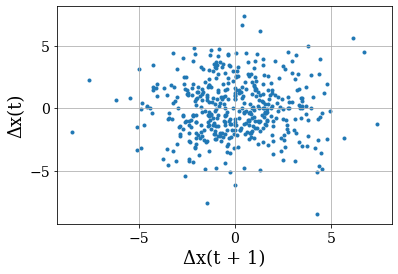

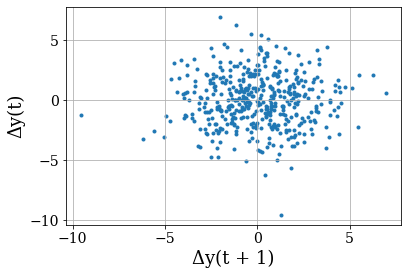

In [14]:
x1 = df_max['Δx'][1:]
x2 = df_max['Δx'][:-1]

plt.scatter(x1, x2, s = 9)
plt.grid(True)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xlabel('Δx(t + 1)', **hfont) ; plt.ylabel('Δx(t)', **hfont)
plt.savefig('pics/1/scatter_autcorr_x.png', dpi = 50, bbox_inches='tight')
plt.show();

y1 = df_max['Δy'][1:]
y2 = df_max['Δy'][:-1]

plt.scatter(y1, y2, s = 9)
plt.grid(True)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xlabel('Δy(t + 1)', **hfont) ; plt.ylabel('Δy(t)', **hfont)
plt.savefig('pics/1/scatter_autcorr_y.png', dpi = 50, bbox_inches='tight')
plt.show()

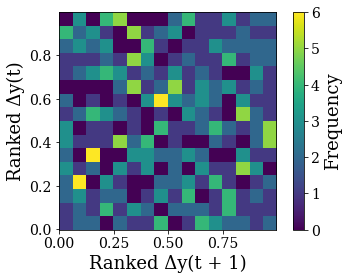

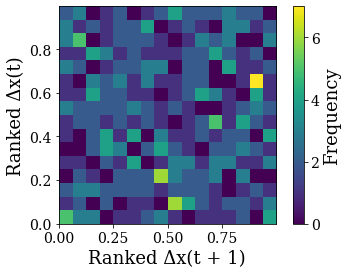

In [15]:
y1_r = qrank(y1)
y2_r = qrank(y2)

heatmap, xedges, yedges = np.histogram2d(y1_r, y2_r, bins=(16, 16))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.ylabel('Ranked Δy(t)', **hfont)
plt.xlabel('Ranked Δy(t + 1)', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.imshow(heatmap, extent=extent)
cbar = plt.colorbar()
cbar.set_label('Frequency', size = 18, family = 'DejaVu Serif')
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_family('DejaVu Serif')
    l.set_size(14)
plt.savefig('pics/1/heatmap_autcorr_x.png', dpi = 50, bbox_inches='tight')
plt.show()

x1_r = qrank(x1)
x2_r = qrank(x2)

heatmap, xedges, yedges = np.histogram2d(x1_r, x2_r, bins=(16, 16))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.ylabel('Ranked Δx(t)', **hfont)
plt.xlabel('Ranked Δx(t + 1)', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.imshow(heatmap, extent=extent)
cbar = plt.colorbar()
cbar.set_label('Frequency', size = 18, family = 'DejaVu Serif')
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_family('DejaVu Serif')
    l.set_size(14)
plt.savefig('pics/1/heatmap_autcorr_y.png', dpi = 50, bbox_inches='tight')
plt.show()

In [16]:
shares = ['PFE', 'GME', 'AMZN', 'AZN', 'DDAIF', 'TSLA', 'TYEKF', 'VWDRY', 'DGV2.F', 'RWEOY']   
#Pfizer, GameStop, Amazon, Astrazeneca, Mercedes, Tesla, Thyssenkrupp, Vestas Wind Systems, ABACUS MNG (Kohle), RWE

yf.pdr_override()
raw_data = pdd.get_data_yahoo(shares, start = '2011-02-11', end = '2021-02-11')
data = raw_data['Adj Close']
data

Symbols,PFE,GME,AMZN,AZN,DDAIF,TSLA,TYEKF,VWDRY,DGV2.F,RWEOY
Date,,,,,,,,,,
2011-02-11,12.371558,13.654530,189.250000,15.724091,56.820793,4.650000,40.172020,9.560765,0.959998,48.115273
2011-02-14,12.516098,13.378474,190.419998,15.691652,56.584332,4.616000,40.026123,9.588110,0.977998,47.619099
2011-02-15,12.516098,13.492932,189.029999,15.844121,55.786331,4.568000,40.026123,9.569880,1.001997,47.056774
2011-02-16,12.667210,13.647796,186.619995,15.951175,53.909554,4.946000,40.026123,9.533423,1.067997,46.739227
2011-02-17,12.726344,13.540066,187.759995,15.967399,53.362766,4.720000,39.734314,9.396710,1.061997,46.937695
...,...,...,...,...,...,...,...,...,...,...
2021-02-05,34.919998,63.770000,3352.149902,48.787014,80.629997,852.229980,11.650000,72.260002,0.063500,43.799999
2021-02-08,34.820000,60.000000,3322.939941,49.110760,80.250000,863.419983,12.060000,71.190002,0.060000,42.299999
2021-02-09,34.970001,50.310001,3305.000000,49.454121,79.690002,849.460022,11.950000,69.559998,0.070000,41.310001


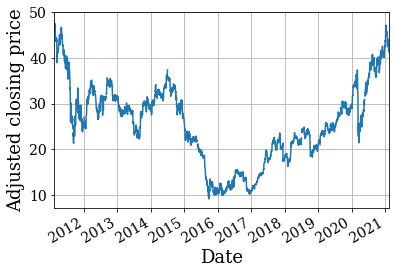

In [17]:
data['RWEOY'].plot()
plt.grid(True)
plt.ylabel('Adjusted closing price', **hfont)
plt.xlabel('Date', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.autoscale(axis = 'x', tight = True);
plt.savefig('pics/2/series_adj_RWE.png', dpi = 50, bbox_inches='tight')
plt.show()

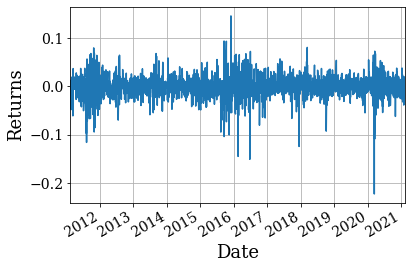

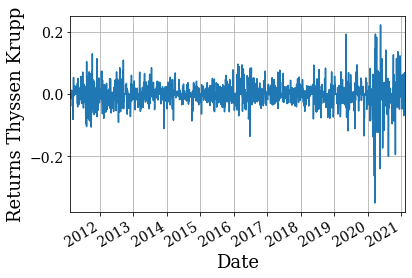

Symbols,PFE,GME,AMZN,AZN,DDAIF,TSLA,TYEKF,VWDRY,DGV2.F,RWEOY
Date,,,,,,,,,,
2011-02-14,0.011548,-0.020634,0.006144,-0.002067,-0.004179,-0.007366,-0.003645,0.002852,0.018405,-0.010420
2011-02-15,0.000000,0.008483,-0.007353,0.009623,-0.014305,-0.010508,0.000000,-0.001905,0.023951,-0.011950
2011-02-16,0.011929,0.011347,-0.012914,0.006711,-0.034813,0.076425,0.000000,-0.003824,0.061798,-0.006794
2011-02-17,0.004647,-0.007956,0.006072,0.001016,-0.010247,-0.047881,-0.007344,-0.014549,-0.005650,0.004228
2011-02-18,-0.009380,-0.008020,-0.006756,0.003240,-0.004032,-0.018119,0.000000,-0.002918,0.027473,0.012526
...,...,...,...,...,...,...,...,...,...,...
2021-02-05,0.000859,0.161048,0.006309,-0.012668,0.022200,0.002628,0.000000,0.002214,-0.047244,0.010959
2021-02-08,-0.002872,-0.062833,-0.008790,0.006592,-0.004735,0.012960,0.033997,-0.015030,-0.058333,-0.035461
2021-02-09,0.004289,-0.192606,-0.005428,0.006943,-0.007027,-0.016434,-0.009205,-0.023433,0.142857,-0.023965


In [18]:
R = data.diff().div(data).dropna()
plt.ylabel('Returns', **hfont)
plt.xlabel('Date', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14);
R['RWEOY'].plot()
plt.grid(True)
plt.autoscale(axis = 'x', tight = True)
plt.savefig('pics/2/series_returns_RWE.png', dpi = 50, bbox_inches='tight')
plt.show()

plt.ylabel('Returns Thyssen Krupp', **hfont)
plt.xlabel('Date', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14);
R['TYEKF'].plot()
plt.grid(True)
plt.autoscale(axis = 'x', tight = True)
plt.savefig('pics/2/example.png', dpi = 50, bbox_inches='tight')
plt.show()

R

In [19]:
for share in shares:
    print(share + ' Mean: ' + str(R[share].mean()))
    print(share + ' Var: ' + str(R[share].var()))
    print(share + ' Skew: ' + str(R[share].skew()))
    print(share + ' Kurt: ' + str(R[share].kurtosis() + 3))

R_k = R.sub(R.mean()).divide(R.std())
R_k

PFE Mean: 0.000299235455912543
PFE Var: 0.00016597798648465854
PFE Skew: -0.23240102799544166
PFE Kurt: 8.787222680192453
GME Mean: -0.0013315735977254529
GME Var: 0.003279372114269852
GME Skew: -9.243909423677687
GME Kurt: 242.50910056005833
AMZN Mean: 0.000807478382230715
AMZN Var: 0.0003875323873940927
AMZN Skew: -0.09252960307486825
AMZN Kurt: 10.1437919207488
AZN Mean: 0.00025705819253262553
AZN Var: 0.0002302697551169014
AZN Skew: -0.9927584142306738
AZN Kurt: 19.375715187872935
DDAIF Mean: -0.00014557020849154012
DDAIF Var: 0.00046740868584971637
DDAIF Skew: -0.7793079641708222
DDAIF Kurt: 16.388912407966217
TSLA Mean: 0.0011438594293265926
TSLA Var: 0.001162063216652134
TSLA Skew: -0.36313797532508985
TSLA Kurt: 9.2578864577874
TYEKF Mean: -0.000754740628448983
TYEKF Var: 0.0009396720325433623
TYEKF Skew: -0.9642495042645719
TYEKF Kurt: 21.233953074937354
VWDRY Mean: -8.540553871745168e-05
VWDRY Var: 0.0009081273860200817
VWDRY Skew: -0.794646182992083
VWDRY Kurt: 13.3735846227

Symbols,PFE,GME,AMZN,AZN,DDAIF,TSLA,TYEKF,VWDRY,DGV2.F,RWEOY
Date,,,,,,,,,,
2011-02-14,0.873156,-0.337072,0.271100,-0.153169,-0.186560,-0.249626,-0.094288,0.097472,0.211815,-0.426795
2011-02-15,-0.023227,0.171383,-0.414552,0.617213,-0.654915,-0.341805,0.024621,-0.060380,0.254462,-0.492102
2011-02-16,0.902732,0.221401,-0.697021,0.425333,-1.603537,2.208380,0.024621,-0.124062,0.545480,-0.272065
2011-02-17,0.337445,-0.115685,0.267405,0.050018,-0.467216,-1.438153,-0.214956,-0.479959,0.026850,0.198330
2011-02-18,-0.751295,-0.116800,-0.384209,0.196579,-0.179747,-0.565074,0.024621,-0.094004,0.281540,0.552452
...,...,...,...,...,...,...,...,...,...,...
2021-02-05,0.043455,2.835533,0.279484,-0.851785,1.033586,0.043549,0.024621,0.076312,-0.292984,0.485568
2021-02-08,-0.246142,-1.073970,-0.487552,0.417479,-0.212288,0.346628,1.133666,-0.495926,-0.378254,-1.495474
2021-02-09,0.309720,-3.340113,-0.316756,0.440601,-0.318305,-0.515643,-0.275668,-0.774765,1.168774,-1.004868


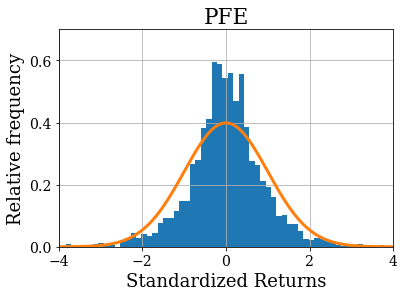

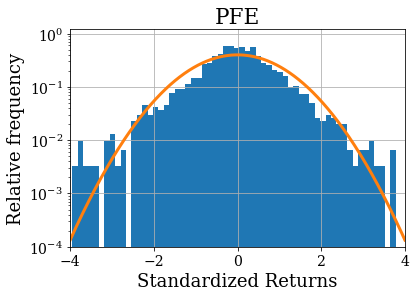

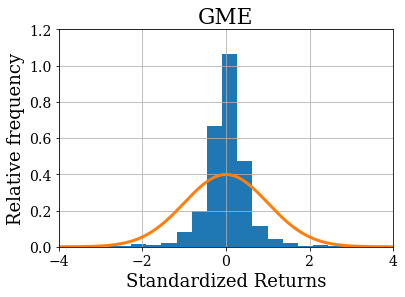

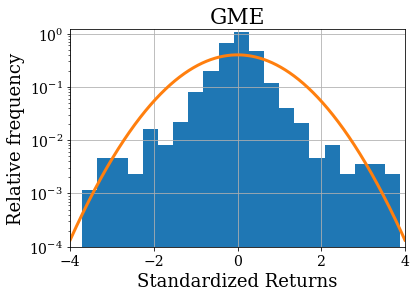

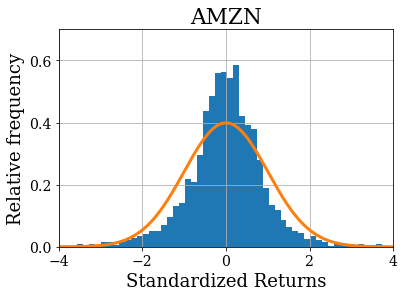

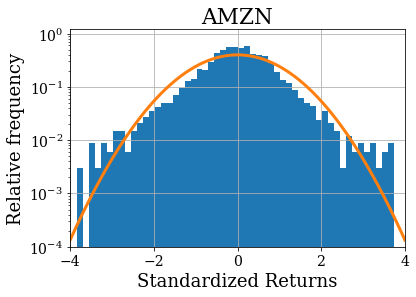

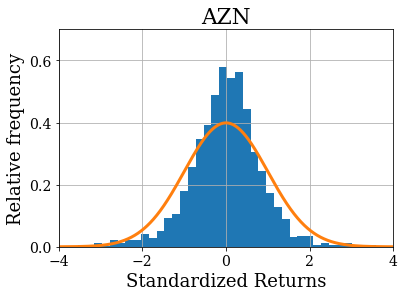

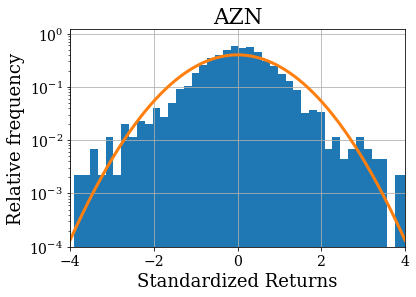

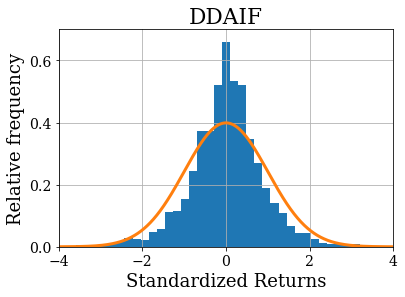

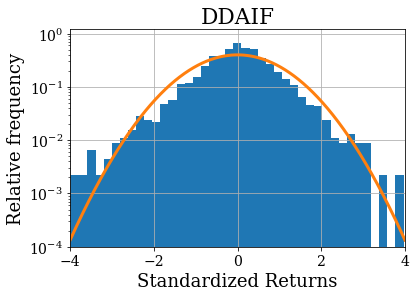

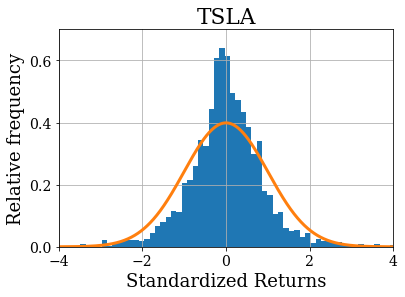

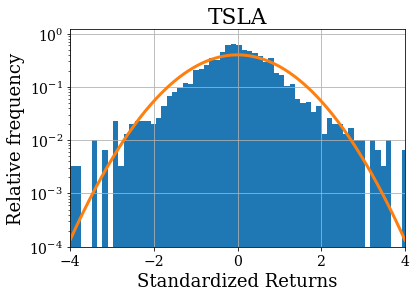

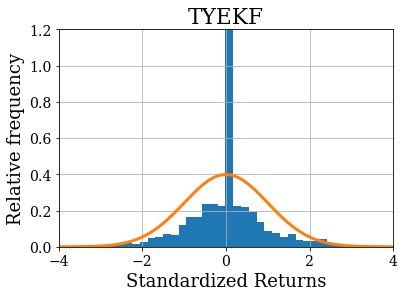

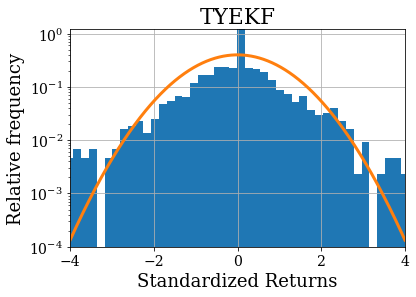

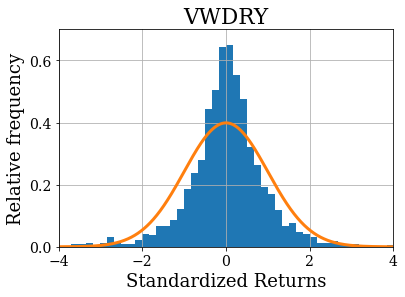

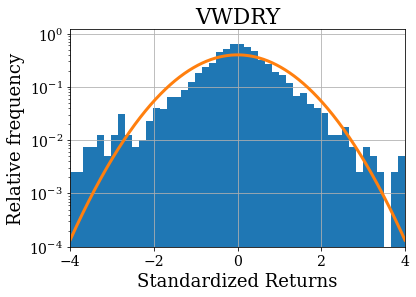

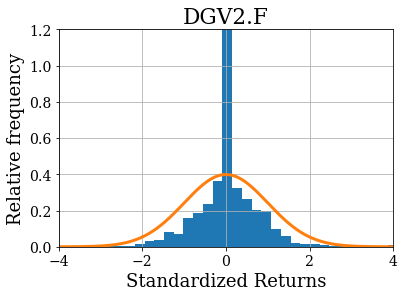

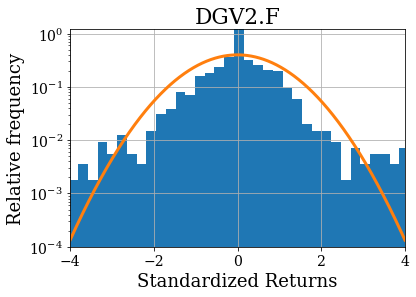

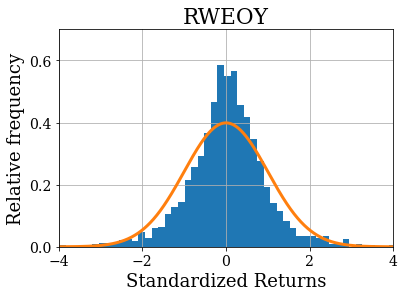

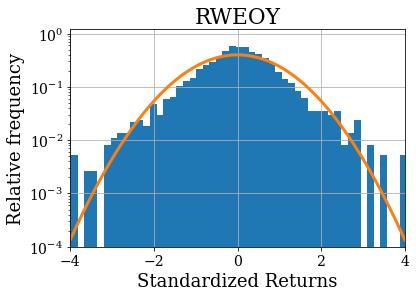

In [20]:
for i, share in enumerate(shares):
    R_k.hist(column = share, density = True, bins = 100)
    plt.plot(np.linspace(-4, 4, 1000), sps.norm.pdf(np.linspace(-4, 4, 1000)), linewidth = 3)
    if i in [0, 2, 3, 4, 5, 7, 9]:
        plt.axis([-4, 4, 0, 0.7])
    else:
        plt.axis([-4, 4, 0, 1.2])
    plt.title(share, **hfont)
    plt.ylabel('Relative frequency', **hfont)
    plt.xlabel('Standardized Returns', **hfont)
    plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
    plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
    plt.savefig('pics/2/std_returns_' + share + '.png', dpi = 50, bbox_inches='tight')
    plt.show()

    R_k.hist(column = share, density = True, bins = 100, log = True)
    plt.semilogy()
    plt.plot(np.linspace(-4, 4, 1000), sps.norm.pdf(np.linspace(-4, 4, 1000)), linewidth = 3)
    plt.axis([-4, 4, 1e-4, 1.2])
    plt.title(share, **hfont)
    plt.ylabel('Relative frequency', **hfont)
    plt.xlabel('Standardized Returns', **hfont)
    plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
    plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
    plt.savefig('pics/2/std_returns_log_' + share + '.png', dpi = 50, bbox_inches='tight')
    plt.show()

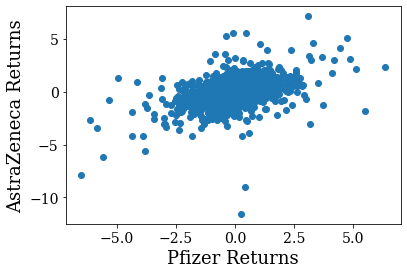

In [21]:
plt.scatter(R_k['PFE'], R_k['AZN'])
plt.ylabel('AstraZeneca Returns', **hfont)
plt.xlabel('Pfizer Returns', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.savefig('pics/2/returns_scatter_PFE_AZN.png', dpi = 50, bbox_inches='tight')
plt.show()

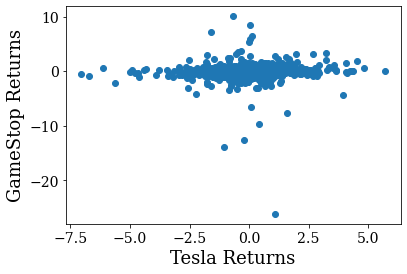

In [22]:
plt.scatter(R_k['TSLA'], R_k['GME'])
plt.ylabel('GameStop Returns', **hfont)
plt.xlabel('Tesla Returns', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.savefig('pics/2/returns_scatter_GME_TSLA.png', dpi = 50, bbox_inches='tight')
plt.show()

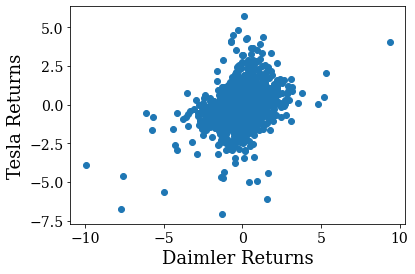

In [23]:
plt.scatter(R_k['DDAIF'], R_k['TSLA'])
plt.ylabel('Tesla Returns', **hfont)
plt.xlabel('Daimler Returns', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.show()

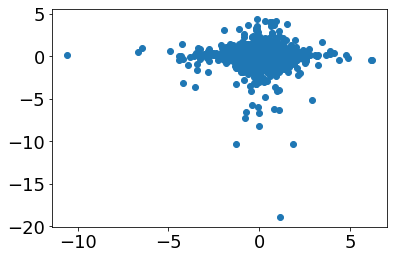

In [24]:
plt.scatter(R_k['VWDRY'], R_k['DGV2.F'])
plt.show()

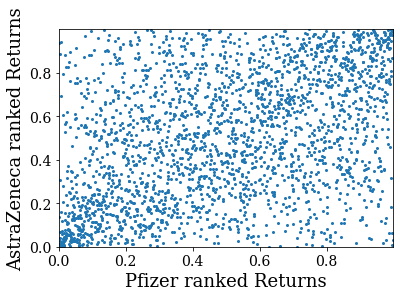

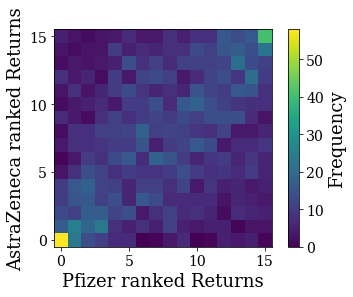

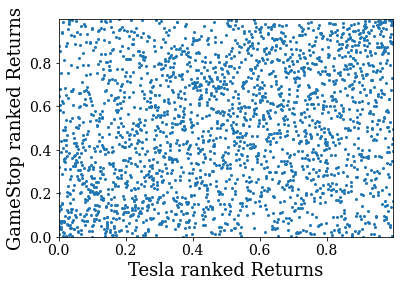

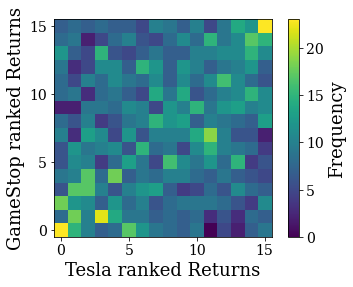

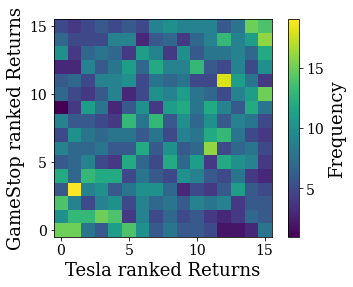

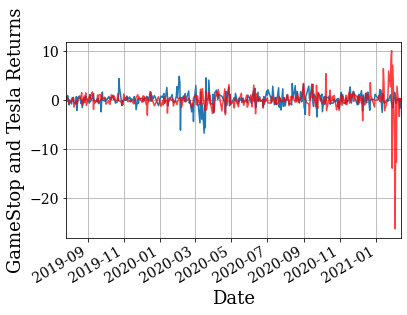

In [25]:
pfe = qrank(R_k['PFE'])
azn = qrank(R_k['AZN'])

plt.scatter(pfe, azn, s = 4)
plt.xlabel('Pfizer ranked Returns', **hfont)
plt.ylabel('AstraZeneca ranked Returns', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.autoscale(tight = True)
plt.savefig('pics/2/returns_scatter_ranked_PFE_AZN.png', dpi = 50, bbox_inches='tight')
plt.show()

heatmap, xedges, yedges = np.histogram2d(pfe, azn, bins=(16, 16))

plt.clf()
plt.xlabel('Pfizer ranked Returns', **hfont)
plt.ylabel('AstraZeneca ranked Returns', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.imshow(heatmap, origin = 'lower')
cbar = plt.colorbar()
cbar.set_label('Frequency', size = 18, family = 'DejaVu Serif')
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_family('DejaVu Serif')
    l.set_size(14)
plt.savefig('pics/2/returns_heatmap_ranked_PFE_AZN.png', dpi = 50, bbox_inches='tight')
plt.show()

tesla = qrank(R_k['TSLA'])
gme = qrank(R_k['GME'])

plt.scatter(tesla, gme, s = 4)
plt.ylabel('GameStop ranked Returns', **hfont)
plt.xlabel('Tesla ranked Returns', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.autoscale(tight = True)
plt.savefig('pics/2/returns_scatter_ranked_GME_TSLA.png', dpi = 50, bbox_inches='tight')
plt.show()

heatmap, xedges, yedges = np.histogram2d(tesla, gme, bins=(16, 16))

plt.clf()
plt.ylabel('GameStop ranked Returns', **hfont)
plt.xlabel('Tesla ranked Returns', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.imshow(heatmap, origin = 'lower')
cbar = plt.colorbar()
cbar.set_label('Frequency', size = 18, family = 'DejaVu Serif')
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_family('DejaVu Serif')
    l.set_size(14)
plt.savefig('pics/2/returns_heatmap_ranked_GME_TSLA.png', dpi = 50, bbox_inches='tight')
plt.show()

tesla = qrank(R_k['TSLA'][:-365])
gme = qrank(R_k['GME'][:-365])

heatmap, xedges, yedges = np.histogram2d(tesla, gme, bins=(16, 16))

plt.clf()
plt.ylabel('GameStop ranked Returns', **hfont)
plt.xlabel('Tesla ranked Returns', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.imshow(heatmap, origin = 'lower')
cbar = plt.colorbar()
cbar.set_label('Frequency', size = 18, family = 'DejaVu Serif')
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_family('DejaVu Serif')
    l.set_size(14)
plt.savefig('pics/2/returns_heatmap_ranked_GME_TSLA_until_2020.png', dpi = 50, bbox_inches='tight')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
R_k['TSLA'][-365:].plot(ax = ax)
R_k['GME'][-365:].plot(ax = ax, color = 'red', alpha = 0.75)
plt.ylabel('GameStop and Tesla Returns', **hfont)
plt.xlabel('Date', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.autoscale(axis = 'x', tight = True)
plt.grid(True)
plt.savefig('pics/2/time_series_tesla_gamestop.png', dpi = 50, bbox_inches='tight')
plt.show()

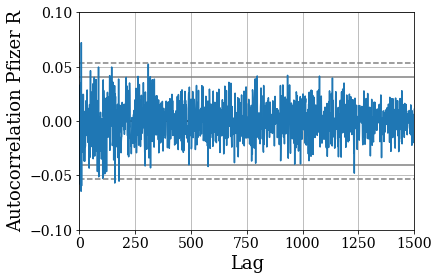

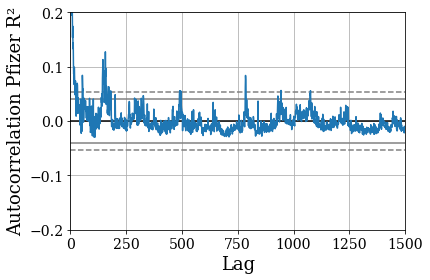

In [26]:
rm = pd.plotting.autocorrelation_plot(R_k['PFE']) 
rm.plot
plt.ylabel('Autocorrelation Pfizer R', **hfont)
plt.xlabel('Lag', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.axis([0, 1500, -0.1, 0.1])
plt.savefig('pics/2/returns_autocorr_PFE.png', dpi = 50, bbox_inches='tight')
plt.show()

rm2 = pd.plotting.autocorrelation_plot(R_k['PFE'].apply(lambda x: x ** 2)) 
rm2.plot
plt.ylabel('Autocorrelation Pfizer R²', **hfont)
plt.xlabel('Lag', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.axis([0, 1500, -0.2, 0.2])
plt.savefig('pics/2/returns_autocorr_PFE_sq.png', dpi = 50, bbox_inches='tight')
plt.show()

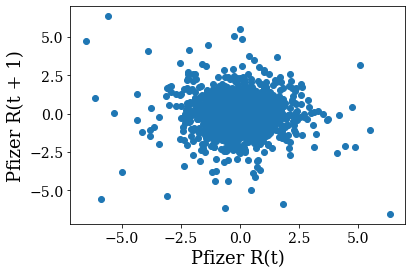

In [27]:
pfe1 = R_k['PFE'][:-1]
pfe2 = R_k['PFE'][1:]

plt.scatter(pfe1, pfe2)
plt.ylabel('Pfizer R(t + 1)', **hfont)
plt.xlabel('Pfizer R(t)', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.savefig('pics/2/returns_autocorr_scatter_PFE.png', dpi = 50, bbox_inches='tight')
plt.show()

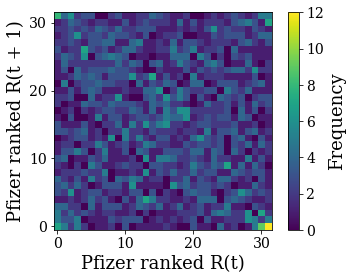

In [28]:
heatmap, xedges, yedges = np.histogram2d(qrank(pfe1), qrank(pfe2), bins=(32, 32))

plt.clf()
plt.ylabel('Pfizer ranked R(t + 1)', **hfont)
plt.xlabel('Pfizer ranked R(t)', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.imshow(heatmap, origin = 'lower')
cbar = plt.colorbar()
cbar.set_label('Frequency', size = 18, family = 'DejaVu Serif')
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_family('DejaVu Serif')
    l.set_size(14)
plt.savefig('pics/2/returns_autocorr_ranked_heatmap_PFE.png', dpi = 50, bbox_inches='tight')
plt.show()

3654
3654
3653
3654
3227
3654
3654
3653
3654
3654


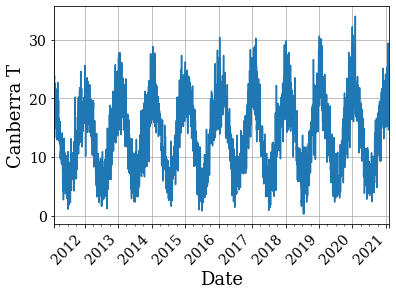

In [29]:
locs = ['Duisburg', 'Munich', 'Sao Paulo', 'Houston', 'Anchorage', 'Buenos Aires', 'St. Petersburg', 'Capetown', 'Beijing', 'Canberra']
stations = [Stations(lat = 51.43255447541353, lon = 6.800788835979209), Stations(lat = 48.112136726828126, lon = 11.577648262186404)]
stations.append(Stations(lat = -23.624908208702756, lon = -46.46244886533699))
stations.append(Stations(lat = 29.761421774856345, lon = -95.34205538962071))
stations.append(Stations(lat = 61.21248946290539, lon = -149.82838837782495))
stations.append(Stations(lat = -34.73232248271822, lon = -58.367538730538925))
stations.append(Stations(lat = 59.9214352225393, lon = 30.353551450337235))
stations.append(Stations(lat = -33.988416855015124, lon = 18.52598649283691))
stations.append(Stations(lat = 39.884160925245155, lon = 116.39399713290861))
stations.append(Stations(lat = -35.32332511410454, lon = 149.1169978599246))

for i, st in enumerate(stations):
    station = st.fetch(1)
    raw_data = Daily(station, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
    raw_data = raw_data.fetch()
    city_data = raw_data['tavg']
    print(len(city_data))
    if i == 9:
        city_data.plot()
        plt.ylabel('Canberra T', **hfont)
        plt.xlabel('Date', **hfont)
        plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
        plt.xticks(fontname = 'DejaVu Serif', fontsize = 14, rotation = 45, ha = "right")
        plt.autoscale(axis = 'x', tight = True) ; plt.grid(True)
        plt.savefig('pics/3/series_canberra.png', dpi = 50, bbox_inches='tight')
        plt.show()

C:\Users\maxim\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\maxim\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


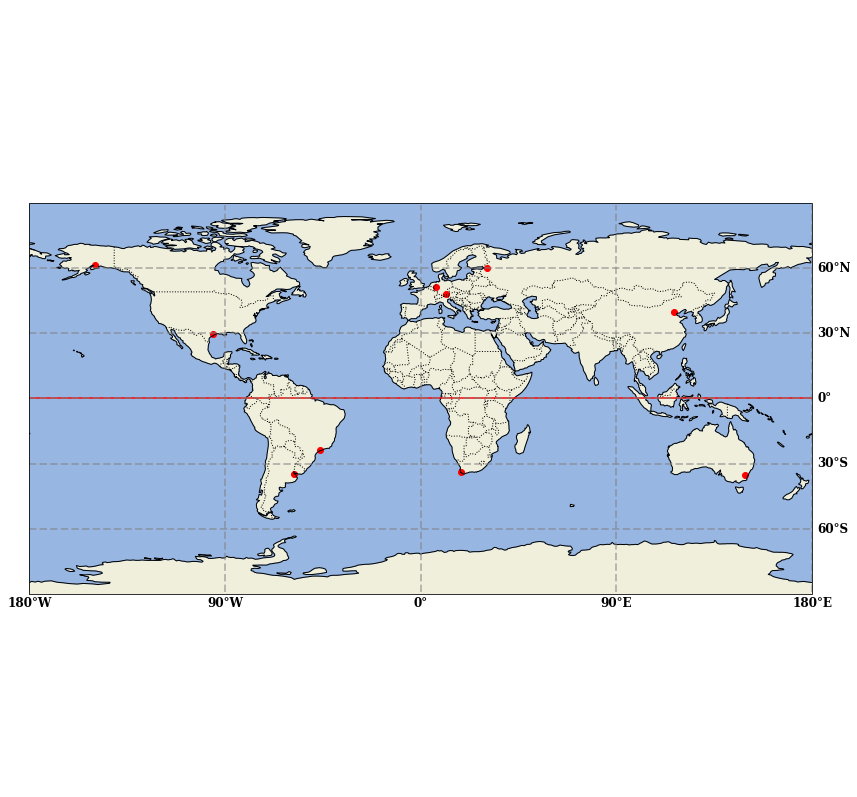

In [30]:
lat = [51.43255447541353, 48.112136726828126, -23.624908208702756, 29.761421774856345, 61.21248946290539, -34.73232248271822, 59.9214352225393, -33.988416855015124, 39.884160925245155, -35.32332511410454]
lon = [6.800788835979209, 11.577648262186404, -46.46244886533699, -95.34205538962071, -149.82838837782495, -58.367538730538925, 30.353551450337235, 18.52598649283691, 116.39399713290861, 149.1169978599246]

fig = plt.figure(figsize = (20.4, 14.4))
#fig.tight_layout()
ax = plt.axes(projection = ccrs.PlateCarree())
ax.add_feature(cpf.LAND)
ax.add_feature(cpf.OCEAN)
ax.add_feature(cpf.COASTLINE)
ax.add_feature(cpf.BORDERS, linestyle=':')
ax.scatter(lon, lat, transform = ccrs.PlateCarree(), color = 'red')
plt.axis([-180, 180, -180, 180])
plt.hlines(0, -180, 180, colors = 'r')

gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlocator = mticker.FixedLocator([-180,-90, 0, 90, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12, 'fontname': 'DejaVu Serif', 'weight': 'bold'}
gl.ylabel_style = {'size': 12, 'fontname': 'DejaVu Serif', 'weight': 'bold'}
plt.savefig('pics/3/map.png', dpi = 50, bbox_inches='tight')
plt.show()

In [31]:
#Example how to deal with missing data, for Anchorage
station = stations[4].fetch(1)
raw_data = Daily(station, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data = raw_data.fetch()
city_data = raw_data['tavg']
prev = datetime(2011, 2, 1)
total = 0
for i, d in enumerate(city_data.index):
    diff = abs((prev - d).days)
    if diff > 1:
        ind = []
        temps = []
        stemp = city_data[i - 1]
        etemp = city_data[i]
        if diff == 13:
            print(prev, d)
        for j in range(1, diff):
            grad = (etemp - stemp) / diff
            temps.append(stemp + j * grad)
            ind.append(prev + timedelta(days = j))
        t = pd.Series(temps, index = ind)
        city_data = city_data.append(t)
    prev = d
print(len(city_data))
city_data = city_data.sort_index()

2018-09-14 00:00:00 2018-09-27 00:00:00
3654


In [32]:
#Test if linear interpolation works correct for longest missing period
for i in range(14):
    print(city_data.index[2782 + i], city_data[2782 + i])

2018-09-14 00:00:00 13.2
2018-09-15 00:00:00 12.838461538461537
2018-09-16 00:00:00 12.476923076923077
2018-09-17 00:00:00 12.115384615384615
2018-09-18 00:00:00 11.753846153846153
2018-09-19 00:00:00 11.392307692307693
2018-09-20 00:00:00 11.03076923076923
2018-09-21 00:00:00 10.669230769230769
2018-09-22 00:00:00 10.307692307692307
2018-09-23 00:00:00 9.946153846153846
2018-09-24 00:00:00 9.584615384615384
2018-09-25 00:00:00 9.223076923076924
2018-09-26 00:00:00 8.861538461538462
2018-09-27 00:00:00 8.5


In [33]:
for i, st in enumerate(stations):
    station = st.fetch(1)
    raw_data = Daily(station, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
    raw_data = raw_data.fetch()
    city_data = raw_data['tavg']
    print(locs[i] + ' Mean: ' + str(city_data.mean()))
    print(locs[i] + ' Var: ' + str(city_data.var()))
    print(locs[i] + ' Skew: ' + str(city_data.skew()))
    print(locs[i] + ' Kurtosis: ' + str(city_data.kurtosis() + 3))

Duisburg Mean: 11.663163656267093
Duisburg Var: 43.379053333734944
Duisburg Skew: 0.03816181128038484
Duisburg Kurtosis: 2.461688348909456
Munich Mean: 10.665790914066783
Munich Var: 58.63771800280827
Munich Skew: -0.05622645528022202
Munich Kurtosis: 2.2731664379959278
Sao Paulo Mean: 20.345743224746744
Sao Paulo Var: 11.928725713895094
Sao Paulo Skew: -0.23300063671194965
Sao Paulo Kurtosis: 2.7909901315974426
Houston Mean: 21.859038089089697
Houston Var: 47.11007811866475
Houston Skew: -0.7174806876082429
Houston Kurtosis: 2.708396696809906
Anchorage Mean: 3.1083359157111854
Anchorage Var: 98.93337438433578
Anchorage Skew: -0.3871381309333581
Anchorage Kurtosis: 2.2723184007791786
Buenos Aires Mean: 17.42074438970992
Buenos Aires Var: 35.34541680133051
Buenos Aires Skew: -0.04279003731013454
Buenos Aires Kurtosis: 2.255698644163405
St. Petersburg Mean: 6.628598795840148
St. Petersburg Var: 85.49887255018767
St. Petersburg Skew: -0.2586241272449226
St. Petersburg Kurtosis: 2.62386184

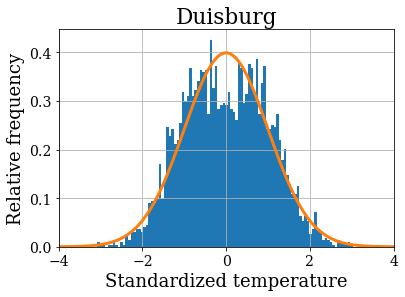

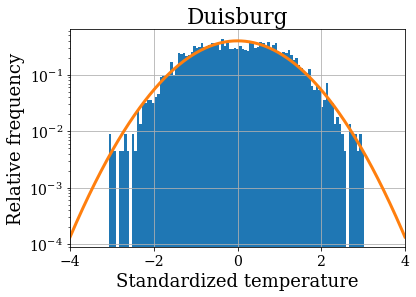

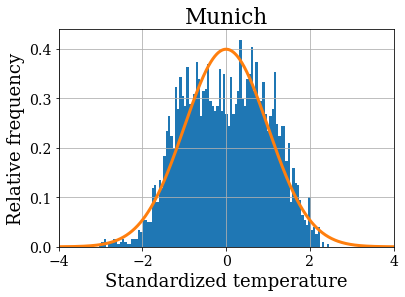

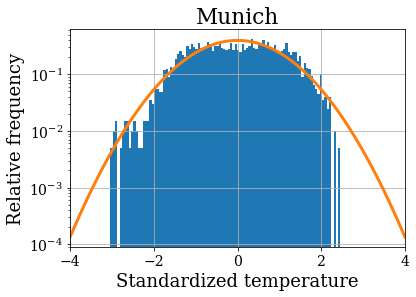

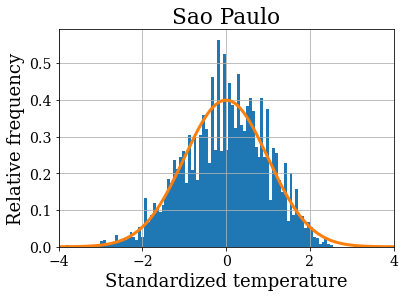

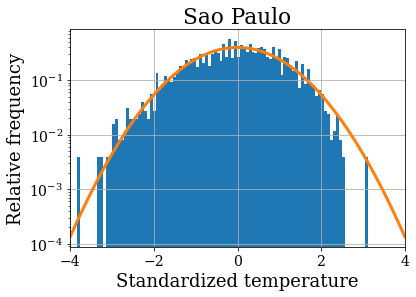

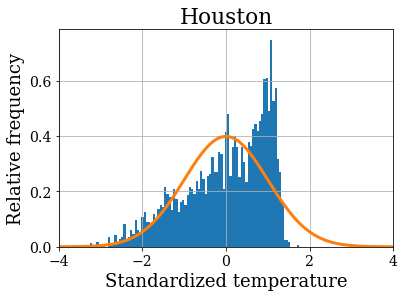

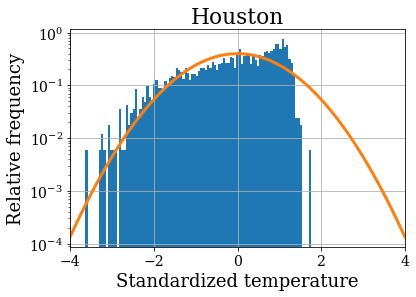

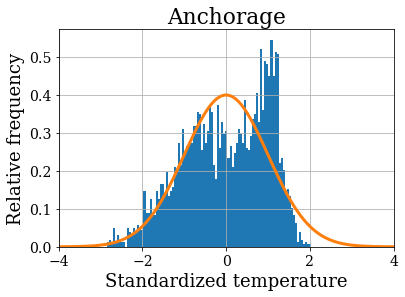

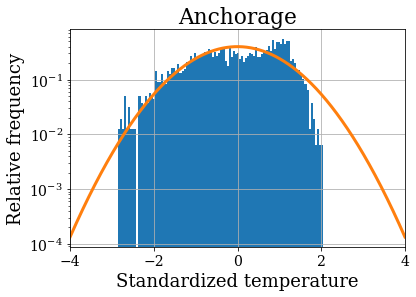

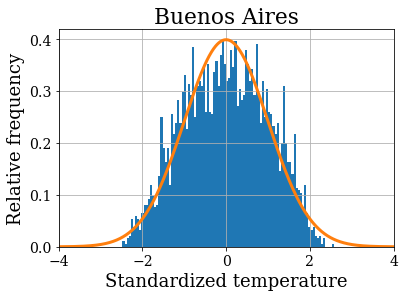

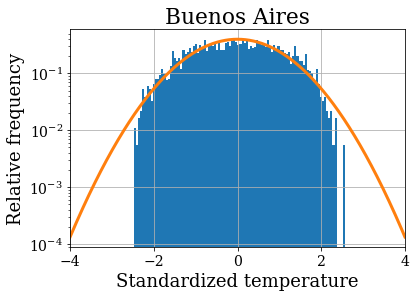

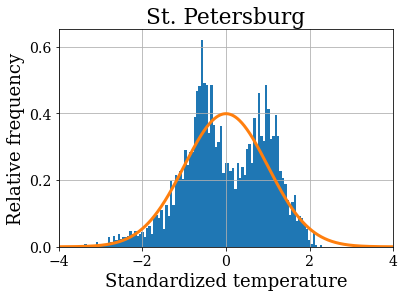

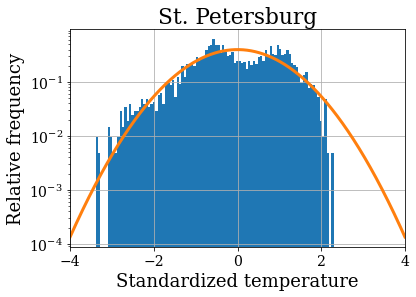

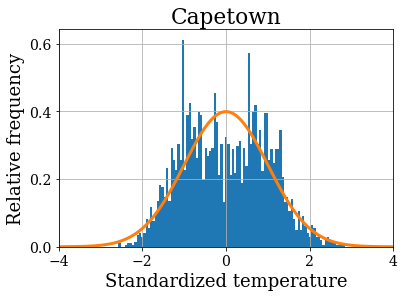

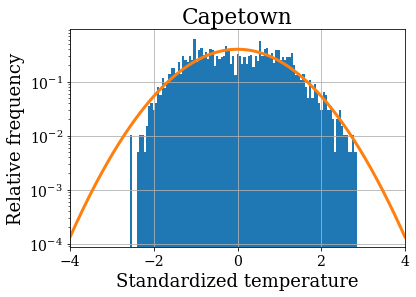

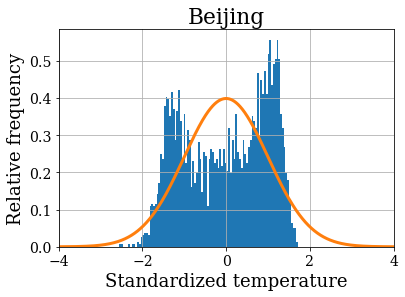

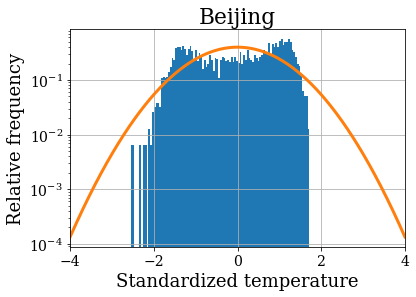

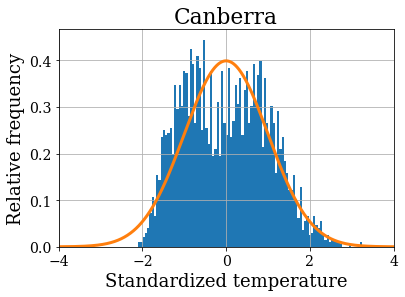

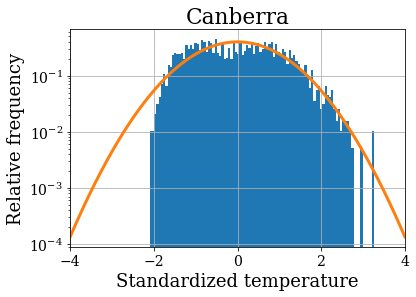

In [34]:
for i, st in enumerate(stations):
    station = st.fetch(1)
    raw_data = Daily(station, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
    raw_data = raw_data.fetch()
    city_data = raw_data['tavg']
    data_n = city_data.sub(city_data.mean()).div(city_data.std())
    data_n.hist(density = True, bins = 100)
    plt.title(locs[i], **hfont)
    plt.plot(np.linspace(-4, 4, 1000), sps.norm.pdf(np.linspace(-4, 4, 1000)), linewidth = 3)
    plt.ylabel('Relative frequency', **hfont)
    plt.xlabel('Standardized temperature', **hfont)
    plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
    plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
    plt.autoscale(axis = 'x', tight = True)
    plt.savefig('pics/3/std_temp_' + locs[i] + '.png', dpi = 50, bbox_inches = 'tight')
    plt.show()
    
    data_n.hist(density = True, bins = 100, log = True)
    plt.semilogy()
    plt.plot(np.linspace(-4, 4, 1000), sps.norm.pdf(np.linspace(-4, 4, 1000)), linewidth = 3)
    plt.title(locs[i], **hfont)
    plt.ylabel('Relative frequency', **hfont)
    plt.xlabel('Standardized temperature', **hfont)
    plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
    plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
    plt.autoscale(axis = 'x', tight = True)
    plt.savefig('pics/3/std_temp_log_' + locs[i] + '.png', dpi = 50, bbox_inches = 'tight')
    plt.show()

1044 129.25971941958628 127.75431162930668


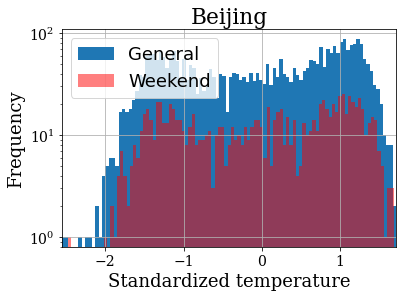

In [35]:
station = stations[8].fetch(1)
raw_data = Daily(station, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data = raw_data.fetch()
city_data = raw_data['tavg']
data_n = city_data.sub(city_data.mean()).div(city_data.std())
data_n_we = []
city_data_we = []
for i, date in enumerate(data_n.index):
    if date.weekday() >= 5:
        data_n_we.append(data_n[i])
        city_data_we.append(city_data[i])
print(len(data_n_we), np.var(city_data), np.var(city_data_we))
data_n.hist(bins = 100, log = True)
plt.hist(data_n_we, 100, facecolor = 'red', alpha = 0.5, log = True)
plt.title('Beijing', **hfont)
#plt.plot(np.linspace(-4, 4, 1000), sps.norm.pdf(np.linspace(-4, 4, 1000)), linewidth = 3)
plt.ylabel('Frequency', **hfont)
plt.xlabel('Standardized temperature', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.autoscale(axis = 'x', tight = True)
plt.legend(['General', 'Weekend'])
plt.savefig('pics/3/smog.png', dpi = 50, bbox_inches = 'tight')
plt.show()

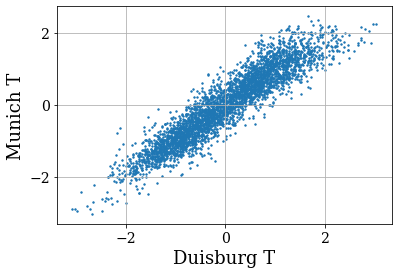

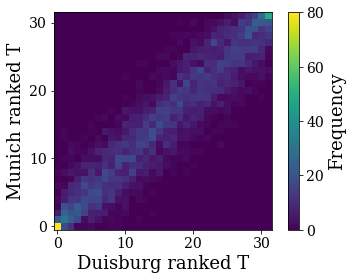

In [36]:
station1 = stations[0].fetch(1)
raw_data1 = Daily(station1, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data1 = raw_data1.fetch()
city_data1 = raw_data1['tavg']
data_n1 = city_data1.sub(city_data1.mean()).div(city_data1.std())

station2 = stations[1].fetch(1)
raw_data2 = Daily(station2, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data2 = raw_data2.fetch()
city_data2 = raw_data2['tavg']
data_n2 = city_data2.sub(city_data2.mean()).div(city_data2.std())

plt.scatter(data_n1, data_n2, s = 2)
plt.ylabel('Munich T', **hfont)
plt.xlabel('Duisburg T', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.grid(True)
plt.savefig('pics/3/temp_scatter_munich_duisburg.png', dpi = 50, bbox_inches = 'tight')
plt.show()

heatmap, xedges, yedges = np.histogram2d(qrank(data_n1), qrank(data_n2), bins=(32, 32))

plt.clf()
plt.ylabel('Munich ranked T', **hfont)
plt.xlabel('Duisburg ranked T', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.imshow(heatmap, origin = 'lower')
cbar = plt.colorbar()
cbar.set_label('Frequency', size = 18, family = 'DejaVu Serif')
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_family('DejaVu Serif')
    l.set_size(14)
plt.savefig('pics/3/temp_heatmap_ranked_munich_duisburg.png', dpi = 50, bbox_inches = 'tight')
plt.show()

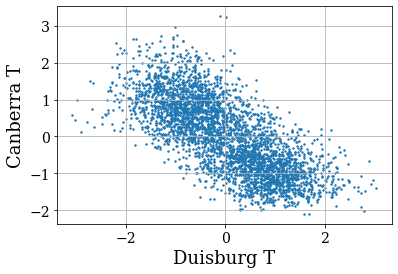

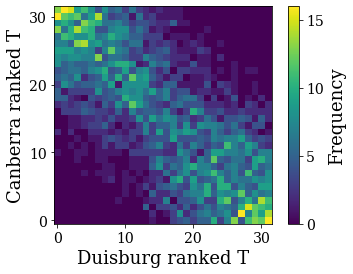

In [37]:
station1 = stations[0].fetch(1)
raw_data1 = Daily(station1, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data1 = raw_data1.fetch()
city_data1 = raw_data1['tavg']
data_n1 = city_data1.sub(city_data1.mean()).div(city_data1.std())

station2 = stations[9].fetch(1)
raw_data2 = Daily(station2, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data2 = raw_data2.fetch()
city_data2 = raw_data2['tavg']
prev = datetime(2011, 2, 1)
total = 0
for i, d in enumerate(city_data2.index):
    diff = abs((prev - d).days)
    if diff > 1:
        ind = []
        temps = []
        stemp = city_data2[i - 1]
        etemp = city_data2[i]
        for j in range(1, diff):
            grad = (etemp - stemp) / diff
            temps.append(stemp + j * grad)
            ind.append(prev + timedelta(days = j))
        t = pd.Series(temps, index = ind)
        city_data2 = city_data2.append(t)
    prev = d
city_data2 = city_data2.sort_index()

data_n2 = city_data2.sub(city_data2.mean()).div(city_data2.std())
    
plt.scatter(data_n1, data_n2, s = 2)
plt.ylabel('Canberra T', **hfont)
plt.xlabel('Duisburg T', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.grid(True)
plt.savefig('pics/3/temp_scatter_canberra_duisburg.png', dpi = 50, bbox_inches = 'tight')
plt.show()

heatmap, xedges, yedges = np.histogram2d(qrank(data_n1), qrank(data_n2), bins=(32, 32))

plt.clf()
plt.ylabel('Canberra ranked T', **hfont)
plt.xlabel('Duisburg ranked T', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.imshow(heatmap, origin = 'lower')
cbar = plt.colorbar()
cbar.set_label('Frequency', size = 18, family = 'DejaVu Serif')
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_family('DejaVu Serif')
    l.set_size(14)
plt.savefig('pics/3/temp_heatmap_ranked_canberra_duisburg.png', dpi = 50, bbox_inches = 'tight')
plt.show()

time
2011-02-01    0.366557
2011-02-02    0.787064
2011-02-03    1.426235
2011-02-04    0.753424
2011-02-05    0.955267
                ...   
2021-01-28    1.123470
2021-01-29    1.039369
2021-01-30    0.332917
2021-01-31    0.080612
2021-02-01    0.467479
Name: tavg, Length: 3654, dtype: float64


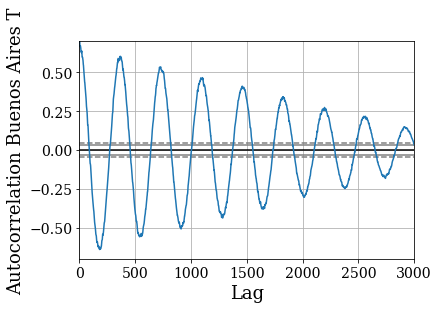

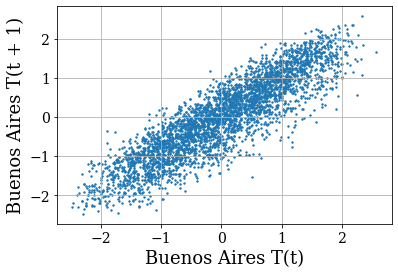

In [38]:
station1 = stations[5].fetch(1)
raw_data1 = Daily(station1, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data1 = raw_data1.fetch()
city_data1 = raw_data1['tavg']
data_n1 = city_data1.sub(city_data1.mean()).div(city_data1.std())
d1 = data_n1[:-1]
d2 = data_n1[1:]

print(data_n1)

d3 = pd.plotting.autocorrelation_plot(data_n1) 
d3.plot
plt.ylabel('Autocorrelation Buenos Aires T', **hfont)
plt.xlabel('Lag', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.axis([0, 3000, -0.7, 0.7])
plt.savefig('pics/3/temp_autocorr_buenos_aires.png', dpi = 50, bbox_inches = 'tight')
plt.show()

plt.scatter(d1, d2, s = 2)
plt.ylabel('Buenos Aires T(t + 1)', **hfont)
plt.xlabel('Buenos Aires T(t)', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.grid(True)
plt.savefig('pics/3/temp_scatter_autocorr_buenos_aires.png', dpi = 50, bbox_inches = 'tight')
plt.show()

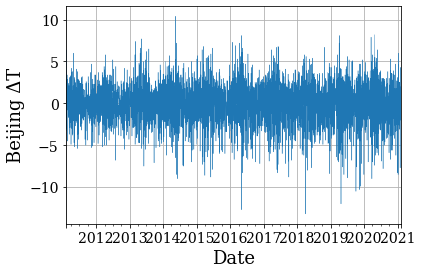

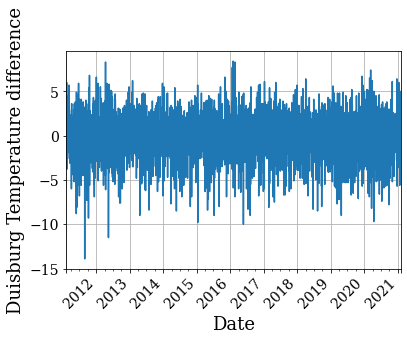

In [39]:
station1 = stations[8].fetch(1)
raw_data1 = Daily(station1, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data1 = raw_data1.fetch()
city_data1 = raw_data1['tavg']
data_dff = city_data1.diff()

data_dff.plot(linewidth = 0.4)
plt.ylabel('Beijing ΔT', **hfont)
plt.xlabel('Date', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.autoscale(axis = 'x', tight = True) ; plt.grid(True)
plt.savefig('pics/3/temp_diff_autocorr_beijing.png', dpi = 50, bbox_inches = 'tight')
plt.show()

station1 = stations[1].fetch(1)
raw_data1 = Daily(station1, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data1 = raw_data1.fetch()
city_data1 = raw_data1['tavg']
data_dff = city_data1.diff()

data_dff.plot()
plt.ylabel('Duisburg Temperature difference', **hfont)
plt.xlabel('Date', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.autoscale(axis = 'x', tight = True) ; plt.grid(True)
plt.xticks(rotation = 45, ha = "right")
plt.savefig('pics/3/example.png', dpi = 50, bbox_inches = 'tight')
plt.show()

In [40]:
for i, st in enumerate(stations):
    station1 = st.fetch(1)
    raw_data1 = Daily(station1, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
    raw_data1 = raw_data1.fetch()
    city_data1 = raw_data1['tavg']
    data_dff = city_data1.diff()

    print(locs[i] + ' Mean: ' + str(data_dff.mean()))
    print(locs[i] + ' Var: ' + str(data_dff.var()))
    print(locs[i] + ' Skew: ' + str(data_dff.skew()))
    print(locs[i] + ' Kurtosis: ' + str(data_dff.kurtosis() + 3))

Duisburg Mean: 0.001532986586367355
Duisburg Var: 4.930517912178297
Duisburg Skew: -0.12040462139541412
Duisburg Kurtosis: 3.5920559452726555
Munich Mean: 0.0026279770052012054
Munich Var: 6.098667790640959
Munich Skew: -0.5271317080450719
Munich Kurtosis: 4.127859327876566
Sao Paulo Mean: 0.0001642935377875126
Sao Paulo Var: 4.207061052156668
Sao Paulo Skew: -0.7776854562689375
Sao Paulo Kurtosis: 4.417950022638617
Houston Mean: -0.007758031442241959
Houston Var: 7.957686800918409
Houston Skew: -1.0056971661200165
Houston Kurtosis: 7.561352267359094
Anchorage Mean: -0.0045567265964041965
Anchorage Var: 6.957371477866343
Anchorage Skew: 0.02906484293862805
Anchorage Kurtosis: 6.069423265313931
Buenos Aires Mean: 0.00016424856282507323
Buenos Aires Var: 7.966155504230816
Buenos Aires Skew: -0.45977258521823033
Buenos Aires Kurtosis: 3.3413522815521435
St. Petersburg Mean: -0.0007391185327128311
St. Petersburg Var: 5.611201534605715
St. Petersburg Skew: 0.021844410930039023
St. Petersbur

3654
3654


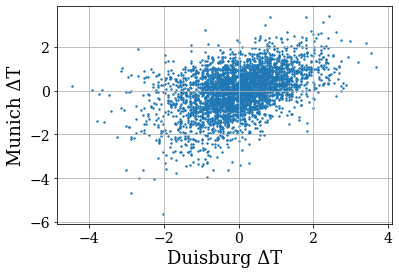

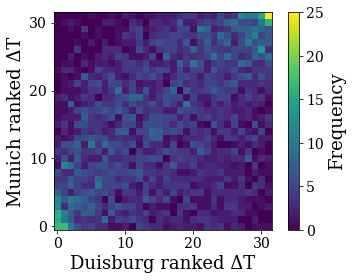

In [41]:
station1 = stations[0].fetch(1)
raw_data1 = Daily(station1, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data1 = raw_data1.fetch()
city_data1 = raw_data1['tavg']
city_data = city_data1.diff()
data_n1 = city_data.sub(city_data.mean()).div(city_data.std())
print(len(data_n1))

station2 = stations[1].fetch(1)
raw_data2 = Daily(station2, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data2 = raw_data2.fetch()
city_data2 = raw_data2['tavg']
city_data_ = city_data2.diff()
data_n2 = city_data_.sub(city_data_.mean()).div(city_data_.std())
print(len(data_n2))

plt.scatter(data_n1, data_n2, s = 2)
plt.ylabel('Munich ΔT', **hfont)
plt.xlabel('Duisburg ΔT', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.grid(True)
plt.savefig('pics/3/temp_diff_scatter_munich_duisburg.png', dpi = 50, bbox_inches = 'tight')
plt.show()

heatmap, xedges, yedges = np.histogram2d(qrank(data_n1), qrank(data_n2), bins=(32, 32))

plt.clf()
plt.ylabel('Munich ranked ΔT', **hfont)
plt.xlabel('Duisburg ranked ΔT', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.imshow(heatmap, origin = 'lower')
cbar = plt.colorbar()
cbar.set_label('Frequency', size = 18, family = 'DejaVu Serif')
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_family('DejaVu Serif')
    l.set_size(14)
plt.savefig('pics/3/temp_diff_ranked_heatmap_munich_duisburg.png', dpi = 50, bbox_inches = 'tight')
plt.show()

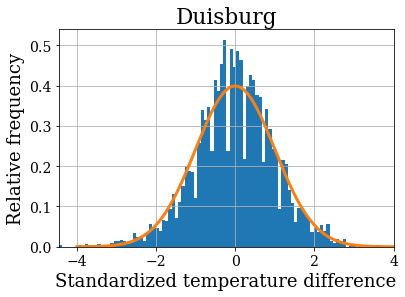

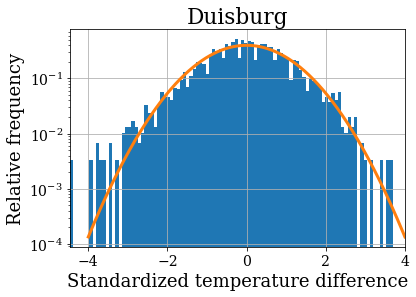

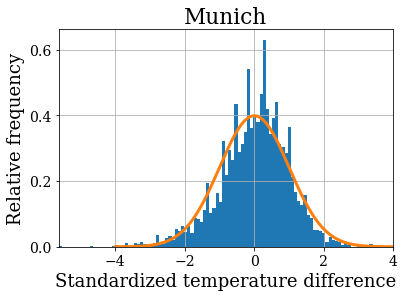

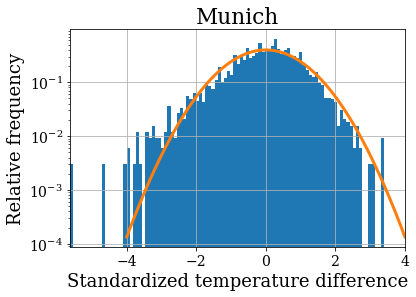

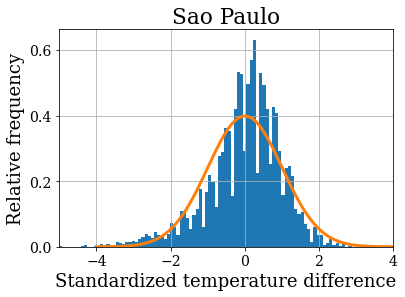

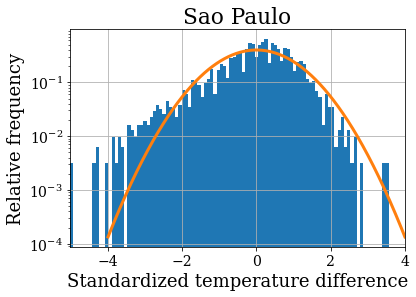

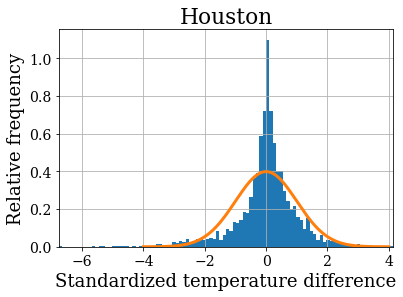

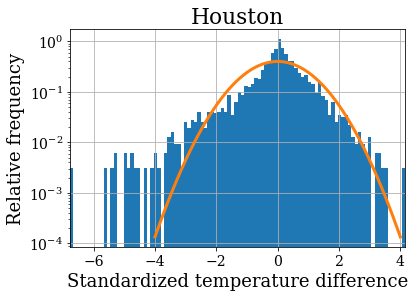

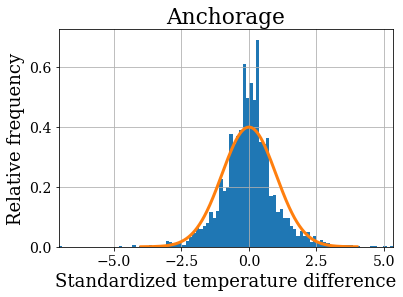

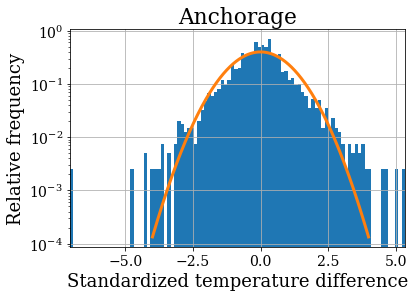

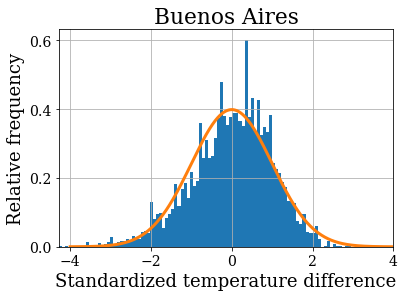

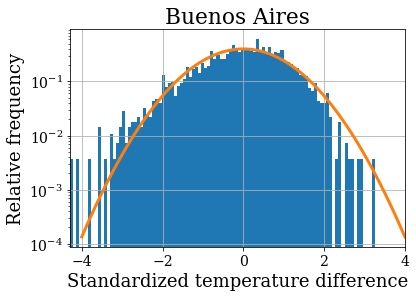

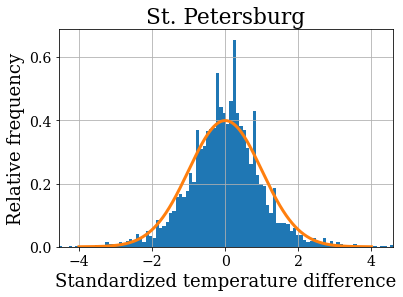

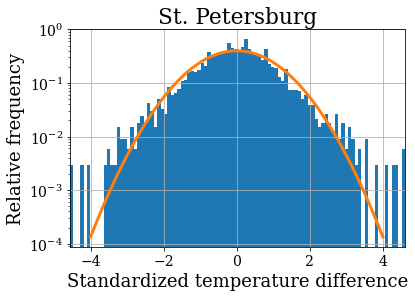

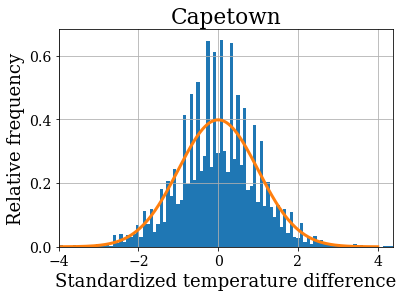

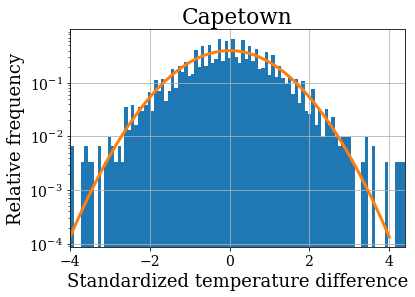

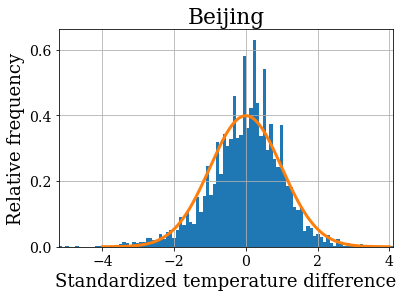

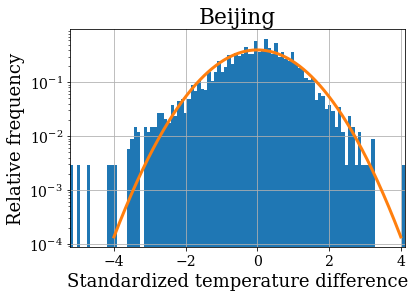

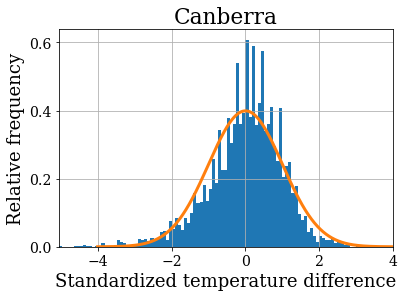

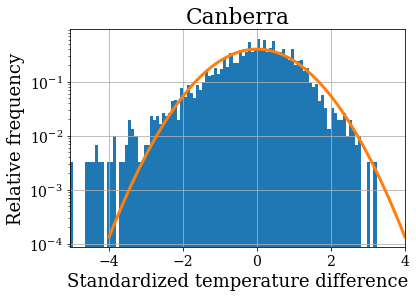

In [42]:
for i, st in enumerate(stations):
    station = st.fetch(1)
    raw_data = Daily(station, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
    raw_data = raw_data.fetch()
    city_data = raw_data['tavg']
    city_data = city_data.diff()
    data_n = city_data.sub(city_data.mean()).div(city_data.std())
    data_n.hist(density = True, bins = 100)
    plt.title(locs[i], **hfont)
    plt.plot(np.linspace(-4, 4, 1000), sps.norm.pdf(np.linspace(-4, 4, 1000)), linewidth = 3)
    plt.ylabel('Relative frequency', **hfont)
    plt.xlabel('Standardized temperature difference', **hfont)
    plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
    plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
    plt.autoscale(axis = 'x', tight = True)
    plt.savefig('pics/3/std_temp_diff_' + locs[i] + '.png', dpi = 50, bbox_inches = 'tight')
    plt.show()
    
    data_n.hist(density = True, bins = 100, log = True)
    plt.semilogy()
    plt.title(locs[i], **hfont)
    plt.plot(np.linspace(-4, 4, 1000), sps.norm.pdf(np.linspace(-4, 4, 1000)), linewidth = 3)
    plt.ylabel('Relative frequency', **hfont)
    plt.xlabel('Standardized temperature difference', **hfont)
    plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
    plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
    plt.autoscale(axis = 'x', tight = True)
    plt.savefig('pics/3/std_temp_diff_log_' + locs[i] + '.png', dpi = 50, bbox_inches = 'tight')
    plt.show()

3654
3654


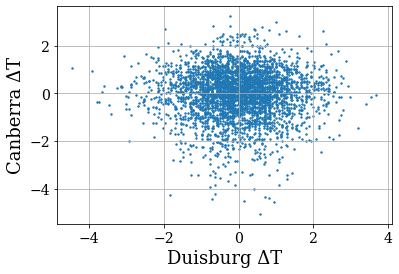

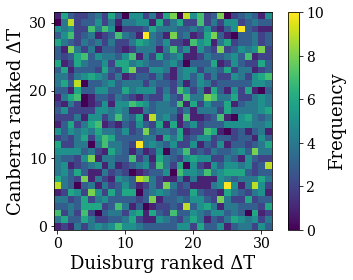

In [43]:
station1 = stations[0].fetch(1)
raw_data1 = Daily(station1, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data1 = raw_data1.fetch()
city_data1 = raw_data1['tavg']
city_data = city_data1.diff()
data_n1 = city_data.sub(city_data.mean()).div(city_data.std())
print(len(data_n1))

station2 = stations[9].fetch(1)
raw_data2 = Daily(station2, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data2 = raw_data2.fetch()
city_data2 = raw_data2['tavg']

prev = datetime(2011, 2, 1)
total = 0
for i, d in enumerate(city_data2.index):
    diff = abs((prev - d).days)
    if diff > 1:
        ind = []
        temps = []
        stemp = city_data2[i - 1]
        etemp = city_data2[i]
        for j in range(1, diff):
            grad = (etemp - stemp) / diff
            temps.append(stemp + j * grad)
            ind.append(prev + timedelta(days = j))
        t = pd.Series(temps, index = ind)
        city_data2 = city_data2.append(t)
    prev = d
city_data2 = city_data2.sort_index()

city_data_ = city_data2.diff()
data_n2 = city_data_.sub(city_data_.mean()).div(city_data_.std())
print(len(data_n2))

plt.scatter(data_n1, data_n2, s = 2)
plt.ylabel('Canberra ΔT', **hfont)
plt.xlabel('Duisburg ΔT', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.grid(True)
plt.savefig('pics/3/temp_diff_scatter_canberra_duisburg.png', dpi = 50, bbox_inches = 'tight')
plt.show()

heatmap, xedges, yedges = np.histogram2d(qrank(data_n1), qrank(data_n2), bins=(32, 32))

plt.clf()
plt.ylabel('Canberra ranked ΔT', **hfont)
plt.xlabel('Duisburg ranked ΔT', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.imshow(heatmap, origin = 'lower')
cbar = plt.colorbar()
cbar.set_label('Frequency', size = 18, family = 'DejaVu Serif')
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_family('DejaVu Serif')
    l.set_size(14)
plt.savefig('pics/3/temp_diff_heatmap_ranked_canberra_duisburg.png', dpi = 50, bbox_inches = 'tight')
plt.show()

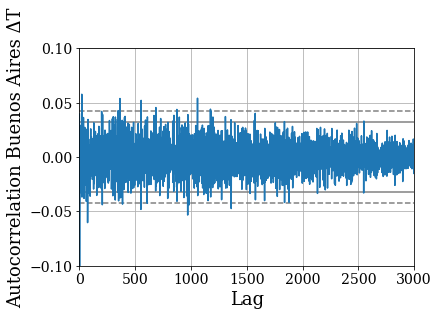

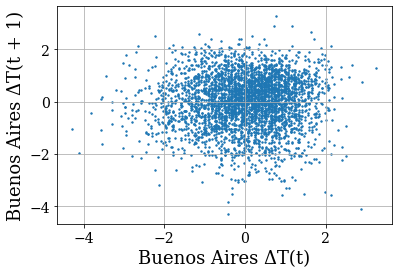

2 -0.29001028843665183


In [44]:
station1 = stations[5].fetch(1)
raw_data1 = Daily(station1, start = datetime(2011, 2, 1), end = datetime(2021, 2, 1))
raw_data1 = raw_data1.fetch()
city_data1 = raw_data1['tavg']
city_data = city_data1.diff()
data_n1 = city_data.sub(city_data.mean()).div(city_data.std()).dropna()

d34 = pd.plotting.autocorrelation_plot(data_n1) 
d34.plot
plt.ylabel('Autocorrelation Buenos Aires ΔT', **hfont)
plt.xlabel('Lag', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.axis([0, 3000, -0.1, 0.1])
plt.savefig('pics/3/temp_diff_autocorr_buenos_aires.png', dpi = 50, bbox_inches = 'tight')
plt.show()

d1 = data_n1[:-1]
d2 = data_n1[1:]

plt.scatter(d1, d2, s = 2)
plt.ylabel('Buenos Aires ΔT(t + 1)', **hfont)
plt.xlabel('Buenos Aires ΔT(t)', **hfont)
plt.yticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.xticks(fontname = 'DejaVu Serif', fontsize = 14)
plt.grid(True)
plt.savefig('pics/3/temp_diff_autocorr_scatter_buenos_aires.png', dpi = 50, bbox_inches = 'tight')
plt.show()

def aut(x):
    return data_n1.autocorr(lag = x)

minv = 1
idmin = 0
for i in range(1, 3001):
    v = aut(i)
    if minv > v:
        minv = v
        idmin = i
print(idmin, minv)